In [54]:
import pickle
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Apply the default theme
sns.set_theme()

In [17]:
strong_results_dir = '../results/results_shadr_token512_epoch5_batch32/strong_model_gt/EleutherAI_pythia-160m/step121000/results.pkl'
weak_results_dir = '../results/results_shadr_token512_epoch5_batch32/weak_model_gt/EleutherAI_pythia-70m/step121000/results.pkl'
strong_transfer_dir = '../results/results_shadr_token512_epoch5_batch32/strong_model_transfer/EleutherAI_pythia-70m_step121000_EleutherAI_pythia-160m_step121000_xent/results.pkl'

# Read the results pickle files
with open(strong_results_dir, 'rb') as f:
    strong = pickle.load(f)
strong_df = pd.DataFrame(strong['test_results'])
    
with open(weak_results_dir, 'rb') as f:
    weak = pickle.load(f)
weak_df = pd.DataFrame(weak['test_results'])

with open(strong_transfer_dir, 'rb') as f:
    strong_transfer = pickle.load(f)
strong_transfer_df = pd.DataFrame(strong_transfer['test_results'])

In [36]:
results_df = pd.concat([strong_df, weak_df, strong_transfer_df], axis=0, keys=['strong', 'weak', 'strong_transfer']).reset_index(level=0)
results_df = results_df.rename(columns={'level_0': 'model'})

In [37]:
results_df.head(5)

,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label
0,strong,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,0,True,"[1.8551090955734253, -1.8551099300384521]","[0.9761124849319458, 0.02388758584856987]"
1,strong,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,1,True,"[-1.036962866783142, 1.0369631052017212]","[0.1116570234298706, 0.8883429169654846]"
2,strong,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,1,True,"[-0.8520811200141907, 0.852081298828125]","[0.1539224088191986, 0.846077561378479]"
3,strong,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,1,True,"[-1.0647871494293213, 1.0647872686386108]","[0.1062554121017456, 0.8937445878982544]"
4,strong,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,0,True,"[1.7307255268096924, -1.7307263612747192]","[0.9695708751678467, 0.030429165810346603]"


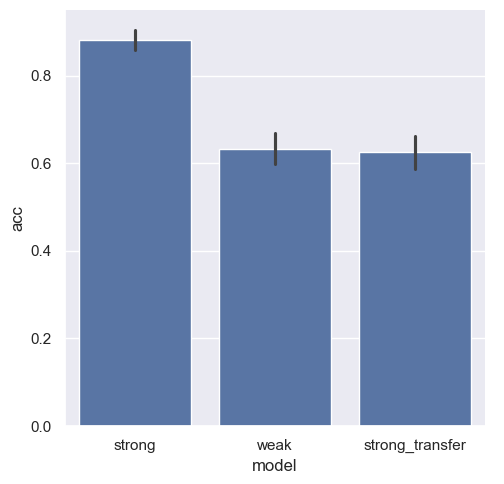

In [40]:
df_list = [strong, weak, strong_transfer]
df_names = ['Strong', 'Weak', 'Strong Transfer']

# Figure 2: Plotting the accuracy test results
sns.catplot(data=results_df, kind="bar", x="model", y="acc")

Text(0.5, 1.0, 'Confusion Matrix (All models)')

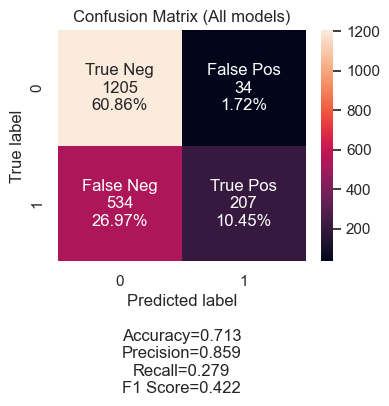

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = list(results_df['gt_label'])
predictions = list(results_df['pred_hard_label'])
cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, annot=labels, fmt='')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label' + stats_text)
plt.title('Confusion Matrix (All models)')

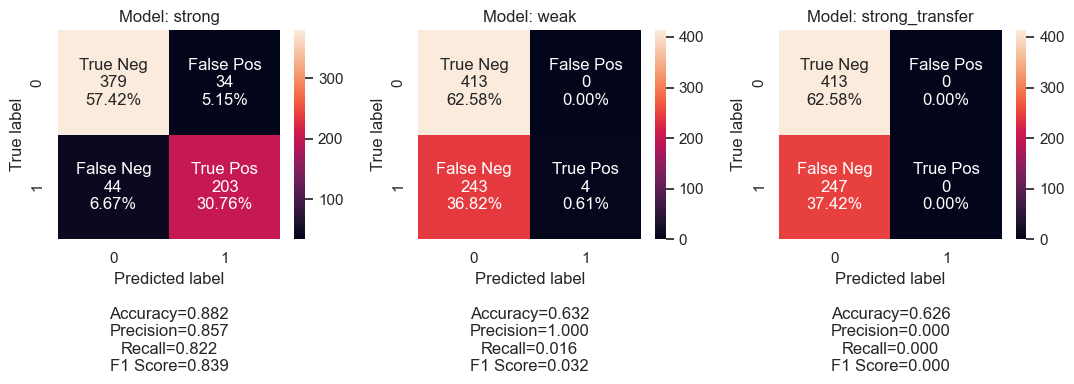

In [84]:
models = ['strong', 'weak', 'strong_transfer']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

for idx, model in enumerate(models):
    df_filtered = results_df[results_df['model'] == model]
    y_test = list(df_filtered['gt_label'])
    predictions = list(df_filtered['pred_hard_label'])
    cf_matrix = confusion_matrix(y_test, predictions)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1, 1] / sum(cf_matrix[:, 1]) if sum(cf_matrix[:, 1]) else 0
    recall = cf_matrix[1, 1] / sum(cf_matrix[1, :]) if sum(cf_matrix[1, :]) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)

    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[idx])
    axes[idx].set_title(f'Model: {model}')
    axes[idx].set_ylabel('True label')
    axes[idx].set_xlabel('Predicted label' + stats_text)

plt.tight_layout()
plt.show()